# Homework 01 

This Jupyter Notebook file is a template that we provide for the homework.
You _must_ use this template and follow the instructions.
You may use codes that were presented in the Lab sessions.
For codes that you have not written (including codes from the Lab) make sure to cite them.


It is important to **carefully read** each assignment and ensure that your answers or code address every part of the assignment.
Make sure to thoroughly understand the requirements before starting.

**Before submitting**, make sure that the entire notebook can be executed with a _fresh_ kernel! (top-left, "Run", "Restart Kernal and Run All Cells") 

<span style="color:red; font-size:18px">**You will fail this homework if the notebook does not run completely.**</span>  
If you cannot solve a part of the tasks, leave them with emphasis (three dots), as shown below.

In [ ]:
### DO NOT EDIT
example_var_with_emphesis = ...
###

# Task overview

Your tasks in this homework consist of
1. Downloading a tile.
2. Visualize the tile.
3. Select three representative points for three classes.
4. Creating a 3-class pixel-wise classification map (plus discussion).
5. Applying a smoothing filter.
6. Recreate the 3-class pixel-wise classification map (plus a discussion of differences).
7. Create a binary pixel-wise classification map and run edge detection (plus discussion).

Details to the individual tasks are listed below.

## 1. Downloading a tile.

First you have to download a tile from [Copernicus Dataspace](https://dataspace.copernicus.eu/).
The tile should have the following properties:
- come from the SENTINEL-2 collection
- be from the area of Wismar (you can use the `osmnx` package to get the envelope of the region)
- have a cloud cover of less than 1.0
- be from the time period of June 2023
- be of type L2A (you can filter by the name of the product)

Hint: If you select a region with the `osmnx` package, you can use the envelope of the region as the area of interest (aoi) in the query.
However, as `osmnx` returns a GeoDataFrame, you have to extract the first element of the envelope attribute to get the right envelope, even if it is a single-element GeoSeries.
This element should be of type `shapely.geometry.polygon.Polygon` and can be converted to a WKT string with the `wkt` attribute (e.g., via `region_gdf.envelope[0].wkt`).

If you cannot download the file, please use the following link to download a file:  
https://tubcloud.tu-berlin.de/s/WEz4gRQzfRdwHjk/download/S2A_MSIL2A_20230708T102601_N0509_R108_T32UPE_20230708T181859.SAFE.zip

In [ ]:
# select a product and download the tile or alternatively download the tile
# if you don't do eigther, you cannot proceed with the following tasks

In [1]:
import requests
from pathlib import Path
from tqdm.rich import tqdm

import pandas as pd
from typing import Optional, Iterable, Tuple

from datetime import date
import osmnx
import rasterio.mask
import geopandas

import zipfile

In [2]:
"""
functionality: get the access token for the copernicus data
source: lab02
"""
def get_access_token(username: str, password: str) -> str:
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post(
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Response from the server was: {r.json()}"
        )
    return r.json()["access_token"]

In [3]:
"""
read credential
source: lab02
"""
user_p = Path("user.txt")
pwd_p = Path("secret.txt")
if user_p.exists():
    user_name = user_p.read_text().strip()
if pwd_p.exists():
    password = pwd_p.read_text().strip()

assert user_name != "", "Please provide your user-name!"
assert password != "", "Please provide your password!"
# return the access token
access_token = get_access_token(user_name, password)

In [4]:
"""
Get dataframe items from the Copernicus DataSpace API

Parameters
    ----------
    collection : str
        The collection to search for. Default is "SENTINEL-2".
    aoi : str, optional
        The area of interest in WKT format. Default is None.
    start_date : str, optional
        The start date in the format "YYYY-MM-DD". Default is None.
    end_date : str, optional
        The end date in the format "YYYY-MM-DD". Default is None.
    attributes : Iterable[Tuple[str, str, float]], optional
        The attributes to filter by. Default is None which means no filtering and is equivalent to an empty list.
        Each tuple should be in the format (key, comparison, value).
        The comparison should be one of "lt", "le", "eq", "ge", "gt".
        Currently only attributes of type double and that are comparable are supported.
    max_returned_items : int, optional
        The maximum number of items to return. Default is 20. Must be in [0, 1000].
Source:
lab02
"""
def dataspace_dataframe_from_attributes(
    collection: str = "SENTINEL-2",
    aoi: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    attributes: Optional[Iterable[Tuple[str, str, float]]] = None,
    max_returned_items: int = 20
):
    if attributes is None:
        attributes = []
    request_str = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter="
    request_str += f"Collection/Name eq '{collection}'"
    if aoi is not None:
        request_str += f" and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}')"
    if start_date is not None:
        request_str += f" and ContentDate/Start gt {start_date}T00:00:00.000Z"
    if end_date is not None:
        request_str += f" and ContentDate/Start lt {end_date}T00:00:00.000Z"
    for k, comp, v in attributes:
        assert comp in ["lt", "le", "eq", "ge", "gt"]
        request_str += f" and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq '{k}' and att/OData.CSC.DoubleAttribute/Value {comp} {v:.2f})"
    # get all attributes
    request_str += "&$expand=Attributes"
    # get top n items
    assert 0 <= max_returned_items <= 1000, f"Copernicus API only allows returned items in [0, 1000], but {max_returned_items} is outside this range."
    request_str += f"&$top={max_returned_items}"
    json_result = requests.get(request_str).json()
    json_vals = json_result['value']
    return pd.DataFrame.from_dict(json_result['value'])

In [5]:
start_date = date(year=2023, month=6, day=1)
end_date = date(year=2023, month=6, day=30)
satellite = "SENTINEL-2"

wismar_gdf = osmnx.geocode_to_gdf("Wismar") # get envelope from GeoSeries
wismar_wkt = wismar_gdf.envelope[0].wkt
print(wismar_wkt)

POLYGON ((11.3907964 53.864659, 11.53379 53.864659, 11.53379 53.9430109, 11.3907964 53.9430109, 11.3907964 53.864659))


In [6]:
products = dataspace_dataframe_from_attributes(
    collection=satellite,
    aoi = wismar_wkt,
    start_date=start_date.strftime("%Y-%m-%d"),
    end_date=end_date.strftime("%Y-%m-%d"),
    attributes=[('cloudCover', 'lt', 1.0)],
     max_returned_items=1000
)
print(len(products))

3


In [7]:
product = products[products['Name'].str.contains("L2A")]
assert len(product) == 1, "Expected only a single result"
product_id = product.iloc[0].Id
product

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint,Attributes
2,application/octet-stream,527a14b2-960a-40d9-b0b1-ef5d4c9baada,S2B_MSIL2A_20230613T102609_N0509_R108_T32UPE_2...,application/octet-stream,1169974940,2023-06-13T17:29:30.596Z,2023-06-13T17:38:45.256Z,2023-07-11T15:22:03.873Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/06/13/S2B_MSIL...,"[{'Value': 'eb0462f6ee786583cb479a0c1d8c299e',...","{'Start': '2023-06-13T10:26:09.025Z', 'End': '...",geography'SRID=4326;POLYGON ((10.5307012563657...,"{'type': 'Polygon', 'coordinates': [[[10.53070...","[{'@odata.type': '#OData.CSC.StringAttribute',..."


In [8]:
"""
functionality: download tile
source: lab04
"""
def download_file_with_progress(url: str, output_file: Path, update_session_headers: dict = None):
    s = requests.Session()
    if update_session_headers is not None:
        s.headers.update(update_session_headers)

    response = s.head(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers['Location']
        response = s.head(url, allow_redirects=False)
        
    chunk_size = 2**20  # MB
    with s.get(url, stream=True) as resp:
        with open(output_file, "wb") as f:
            print(f"Saving to {output_file}")
            for data in tqdm(
                resp.iter_content(chunk_size=chunk_size), 
                total=int(resp.headers.get("content-length", 0)) // chunk_size, 
                unit="MB",
                unit_scale=True,
                desc="Downloading...",
            ):
                f.write(data)

In [9]:
data_path = Path("./data")
data_path.mkdir(exist_ok=True)
assert data_path.exists, "Should exist after calling mkdir!"

tile_name = Path(product.iloc[0].Name)
output_filepath = data_path / tile_name.with_suffix(".SAFE.zip")

if not output_filepath.exists():
    url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    download_file_with_progress(
        url=url, 
        output_file=output_filepath, 
        update_session_headers={'Authorization': f'Bearer {access_token}'}
    )

In [10]:
unzipped_dir = Path(data_path / tile_name.with_suffix(".SAFE"))
if not unzipped_dir.exists():
    zipf = zipfile.ZipFile(output_filepath)
    zipf.extractall(path="data")
assert unzipped_dir.exists(), f"{unzipped_dir} does not exist!"

## 2. Visualize the tile.

After downloading the tile, you should visualize it. For this, you can use everything you learned in the Lab sessions. Create a false-color image of the region of interest (Wismar) and display it.  
Display only the region of interest, not the entire tile. You may display it using the area's envelope instead of the pure shape.

Evaluate if there are any pixels with no data and print the result of your evaluation. Use a 3-channel image with the bands NIR, Red, and Green for the visualization of the red, green and blue channels, respectively (in this order as RGB image).

Use the 10m bands for the visualization.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def read_s2_jp2_data_with_clipping(
    band_data_path: Path, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
) -> np.ndarray:
    """
    Given the `band_data_path` to a JP2000 encoded GeoTIFF file, return those parts that are overlapping with the
    `clip_geoseries` GeoSeries. By default, the bounding box (`envelope`) of the geometry will be used to define the
    region of interest.
    """
    # open the GeoTIFF file which also contains the CRS metadata
    with rasterio.open(band_data_path) as data:
        # ensure that the data is using the same coordinate reference system and reproject if they don't
        reprojected_geoseries = clip_geoseries.to_crs(data.crs)
        # use the bounding box if `envelope` is set => Make sure that the matrix we get back can contain
        # only valid values
        reprojected_geoseries = (
            reprojected_geoseries.envelope if envelope else reprojected_geoseries
        )
        # Use crop to only return the matrix that contains our region of interest
        # Use `all_touched=True` to make sure that the border is also conisdered "inside" the region of interest
        out_img, _out_transform = rasterio.mask.mask(
            data, reprojected_geoseries, crop=True, all_touched=True
        )
        # drop singleton axes
        out_img = out_img.squeeze()
    return out_img

In [108]:
"""
visualization
source: lab04
"""
def quant_norm_data(
        data: np.ndarray, lower_quant: float = 0.01, upper_quant: float = 0.99
) -> np.ndarray:
    masked_data = np.ma.masked_equal(data, 0)
    lq, uq = np.quantile(masked_data.compressed(), (lower_quant, upper_quant))
    data = np.clip(data, a_min=lq, a_max=uq)
    data = (data - lq) / (uq - lq)
    return data


def vis(data: np.ndarray, quant_norm: bool = False):
    if quant_norm:
        data = quant_norm_data(data)
    if data.ndim == 2:
        plt.imshow(data, cmap="gray")
    elif data.ndim == 3:
        plt.imshow(data)
    else:
        raise ValueError(f"Expected data to have 2 or 3 dimensions, but got {data.ndim} dimensions.")
    # plt.axis("off")
    plt.show()

class S2TileReader:
    def __init__(self, directory: Path):
        assert directory.is_dir(), f"{directory} is not a directory"
        self.image_files = list(directory.glob(f"**/IMG_DATA/*.jp2"))
        if len(self.image_files) == 0:
            self.image_files = list(directory.glob(f"**/IMG_DATA/R60m/*.jp2"))
            self.image_files.extend(list(directory.glob(f"**/IMG_DATA/R20m/*.jp2")))
            self.image_files.extend(list(directory.glob(f"**/IMG_DATA/R10m/*.jp2")))
        self.band2file_mapping = self._bands()
        self.bands = sorted(self.band2file_mapping.keys())
        print(f"{len(self.band2file_mapping)} images found in {directory}")

    def _bands(self):
        return {"_".join(x.stem.split("_")[2:]):x for x in self.image_files}

    def read_band(self, band: str):
        assert band in self.bands, f"Band {band} invalid. Please select one of {self.bands}"
        img_path = self.band2file_mapping[band]
        with rasterio.open(self.band2file_mapping[band]) as f:
            data = f.read()
        if data.shape[0] == 1:
            return data.squeeze(0)
        elif data.shape[0] == 3:
            return np.transpose(data, (1, 2, 0))
        
    def read_band_data_with_clipping(
        self, band: str, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
    ) -> np.ndarray:
        assert band in self.bands, f"Band {band} invalid. Please select one of {self.bands}"
        img_path = self.band2file_mapping[band]
        return read_s2_jp2_data_with_clipping(img_path, clip_geoseries, envelope=envelope)

36 images found in data/S2B_MSIL2A_20230613T102609_N0509_R108_T32UPE_20230613T151004.SAFE


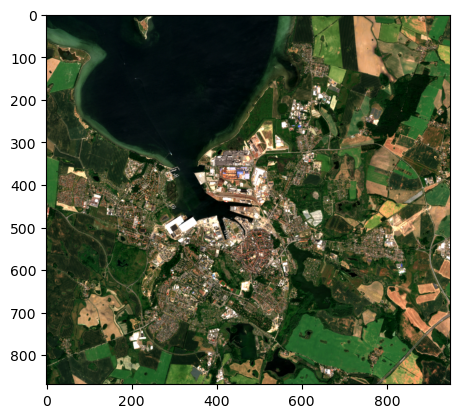

In [124]:
# extract the tile, read the bands (clipped), display the bands
s2_reader = S2TileReader(unzipped_dir)
clipped_rgb_arr = np.stack(
    [
        s2_reader.read_band_data_with_clipping(b, wismar_gdf.geometry)
        for b in ("B04_10m", "B03_10m", "B02_10m")
    ],
    axis=-1,
)
vis(clipped_rgb_arr, quant_norm=True)

In [16]:
assert not (clipped_rgb_arr == 0).any(),  "There is an unexpected <NO_DATA> value!"

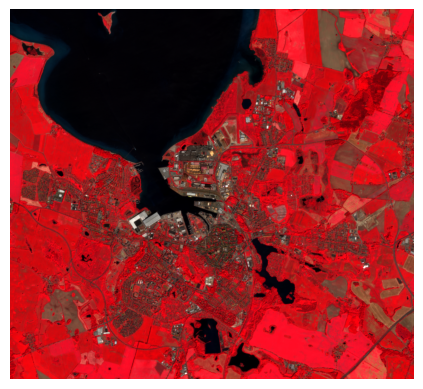

In [11]:
clipped_rgb_arr_fc = np.stack(
    [
        s2_reader.read_band_data_with_clipping(b, wismar_gdf.geometry)
        for b in ("B08_10m", "B04_10m", "B03_10m")
    ],
    axis=-1,
)
vis(clipped_rgb_arr_fc, quant_norm=True)

## 3. Selecting three representative points for three classes.

Select three representative points for three classes in the region of interest (you may hardcode the selection). The classes should be:
1. Water
2. Vegetation
3. Urban

Everything that is not one of the classes (also for the following tasks) we will consider as "Other".

Visualize the region of interest with the three points as markers.
Also, visualize the spectral signature of the three points.

You may use any band resolution you want for the spectral signature visualization.
You can also ignore band 8 for the rest of this homework.

In [18]:
from shapely.geometry import Point
from typing import Sequence

In [19]:
# select the points
lclu_gdf = geopandas.GeoDataFrame(
    {"type": ["water", "vegetation", "urban"]},
    geometry=[
        Point(11.434485, 53.922314),
        Point(11.480413, 53.876378),
        Point(11.464598, 53.894228)
    ],
    crs="epsg:4326",
)

In [20]:
#  explore the points and the region
lclu_gdf.reset_index().explore(marker_type="marker")

In [21]:
AVAILABLE_BANDS = [b for b in s2_reader.bands if "B" in b and "8" not in b]

In [22]:
"""
functionality: get points from tile
source: lab02
"""
def read_points_from_tile(
    s2_reader: S2TileReader,
    points_series: geopandas.GeoSeries,
    bands: Sequence[str] = AVAILABLE_BANDS,
) -> np.ndarray:
    if set(lclu_gdf.geom_type) != {"Point"}:
        raise ValueError("Only point geometries are allowed!")
    return np.array([s2_reader.read_band_data_with_clipping(b, points_series) for b in bands])

In [23]:
# display the spectral signature
water_spectral_sig = read_points_from_tile(s2_reader, lclu_gdf.query("type == 'water'").geometry)
vegetation_spectral_sig = read_points_from_tile(s2_reader, lclu_gdf.query("type == 'vegetation'").geometry)
urban_spectral_sig = read_points_from_tile(s2_reader, lclu_gdf.query("type == 'urban'").geometry)

In [24]:
lclu_gdf

,type,geometry
0,water,POINT (11.43449 53.92231)
1,vegetation,POINT (11.48041 53.87638)
2,urban,POINT (11.46460 53.89423)


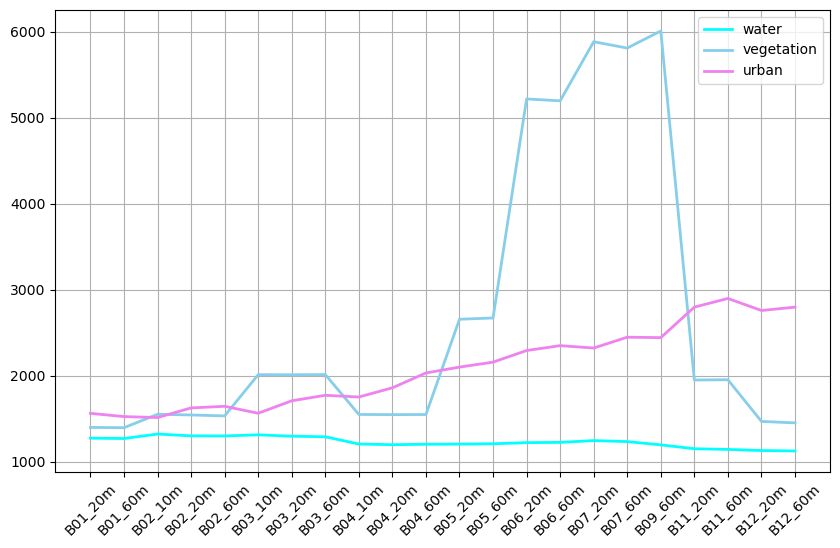

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(AVAILABLE_BANDS, water_spectral_sig, label="water", linewidth=2, color="aqua")
plt.plot(AVAILABLE_BANDS, vegetation_spectral_sig, label="vegetation", linewidth=2, color="skyblue")
plt.plot(AVAILABLE_BANDS, urban_spectral_sig, label="urban", linewidth=2, color="violet")
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.grid()

## 4. Creating a 3-class pixelwise-classification map (plus discussion).

Create a 3-class pixelwise-classification map for the region of interest. Use the envelope of the region of interest as the area of interest for the classification.
Use the representative points as a very simple approximation for a classifier. 
For each pixel in the region of interest, select one of the classes based on a simple distance measure by your choice (e.g., Euclidean distance). 
Take all bands into account for the classification (except band 8). 
If you think that some bands are more important than others, you can give them more weight in the distance measure.

If any of the pixels in the image are not classified, assign them to the class "Other".

Visualize the classification map and discuss the results.

*Hint: You may interpolate the data to 60m resolution to speed up the classification process and ease the process. 
You only need to interpolate the data if the respective band is not already in the desired resolution.*You only need to interpolate the data if the respective band is not already in the desired resolution.*

In [364]:
class Clf():
    def __init__(self, band: str, points):
        self.band = band
        self.points = points
        self.clss = points.keys()
        self.AVAILABLE_BANDS = [b for b in s2_reader.bands if "B" in b and self.band in b]
        self.clipped_rgb_arr =  quant_norm_data(np.stack(
            [
                s2_reader.read_band_data_with_clipping(b, wismar_gdf.geometry)
                for b in ("B04_"+band+"m", "B03_"+band+"m", "B02_"+band+"m")
            ], 
            axis=-1,
        ))
        self.img_spec_mat = np.stack([
            s2_reader.read_band_data_with_clipping(b, wismar_gdf.geometry)
            for b in self.AVAILABLE_BANDS
            ],
            axis = -1
        )
        self.points_spec_mat = dict(zip(self.clss, [self.img_spec_mat[p[0],p[1], :] for p in self.points.values()]))
        self.distance_mat = dict()
        self.height, self.width = self.clipped_rgb_arr.shape[0], self.clipped_rgb_arr.shape[1]
        self.threshold_mat = dict()
        
    def cal_euclidean_distance(self, clss, weights):
        distances = np.zeros((self.height, self.width))
        for i in range(self.height):
            for j in range(self.width):
                distances[i, j] = np.linalg.norm(weights * (self.img_spec_mat[i, j, :] - self.points_spec_mat[clss]))
        return quant_norm_data(distances)
    
    def gen_distance_mat(self, clss, weights):
        self.distance_mat[clss] = self.cal_euclidean_distance(clss, weights)

    def vis_euclidean_mat(self):
        color = ['aqua','skyblue','violet']
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        axes[0,0].imshow(self.clipped_rgb_arr)
        for clss, clr in zip(self.clss, color):
            axes[0,0].scatter(self.points[clss][0], self.points[clss][1], color=clr, s=80, edgecolor='black', label=clss)
        axes[0,0].legend()
        axes[0,0].axis("off")
        
        for idx, clss, clr in zip([[0,1],[1,0],[1,1]], self.clss, color):
            im = axes[idx[0],idx[1]].imshow(self.distance_mat[clss])
            fig.colorbar(im, ax=axes[idx[0],idx[1]],shrink=0.5)
            axes[idx[0],idx[1]].scatter(self.points[clss][0], self.points[clss][1], color=clr, s=80, edgecolor='black', label=clss)
            
        plt.show()
        
    def gen_threshold_mat(self, clss, threshold, condition=1):
        if condition:
            self.threshold_mat[clss] = np.where(wismar_10m.distance_mat[clss] >= threshold, 1, 0)
        else:
            self.threshold_mat[clss] = np.where(wismar_10m.distance_mat[clss] <= threshold, 1, 0)
            
    def vis_threshold_mat(self):
        fig, axes = plt.subplots(1, 3, figsize=(10, 10))
        for idx, clss in zip(range(3), self.clss):
            axes[idx].imshow(self.threshold_mat[clss])
                             
    def gen_vis_clf_map(self):
        clf_map = np.zeros((self.height,self.width,3),dtype=np.uint8)
        clf_map[self.threshold_mat["urban"]==1] = red
        clf_map[self.threshold_mat["water"]==1] = blue
        clf_map[self.threshold_mat["vegetation"]==1] = green
        plt.imshow(clf_map)
        plt.show()
        return clf_map

In [365]:
points_10m = {"water":[300, 200], "vegetation":[670, 790], "urban":[450, 400]}
wismar_10m = Clf('10', points_10m)

In [ ]:
"""
src: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/bands/
B02_10m: soil and vegetation discrimination
B03_10m: vegetation, clear water
B04_10m: vegetation types, soils and urban area
B08_10m: NIR, shorelines and biomass content, vegetation
"""
# wismar_10m.gen_distance_mat("water", [0,80,0,0])
# wismar_10m.gen_distance_mat("vegetation", [80,5,0,80])
# wismar_10m.gen_distance_mat("urban", [0,0,50,0])

In [366]:
wismar_10m.gen_distance_mat("water", [0,80,0,0])

In [367]:
wismar_10m.gen_distance_mat("vegetation", [80,5,0,80])

In [368]:
wismar_10m.gen_distance_mat("urban", [0,10,500,0])

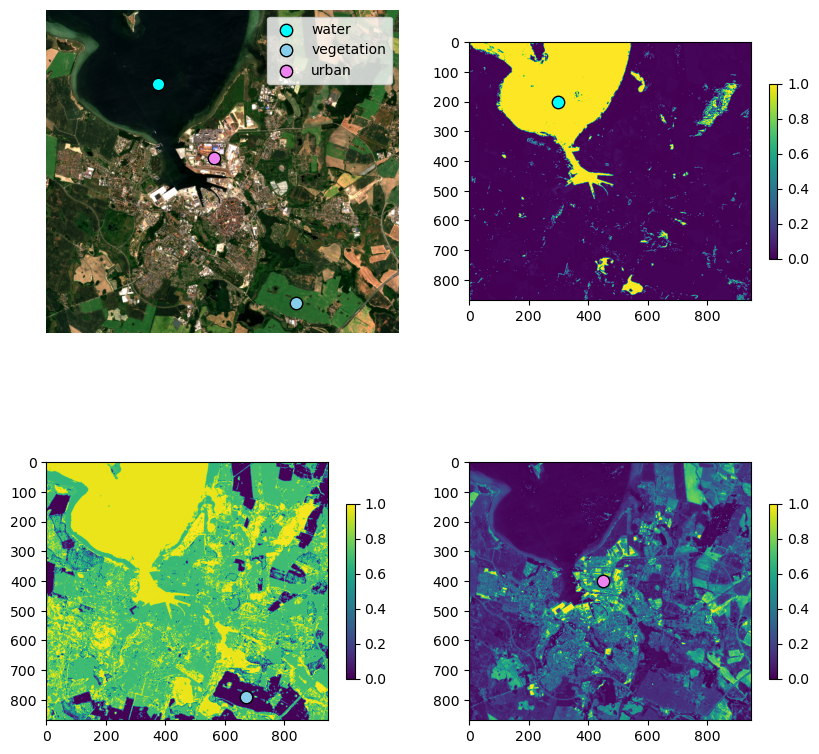

In [369]:
wismar_10m.vis_euclidean_mat()

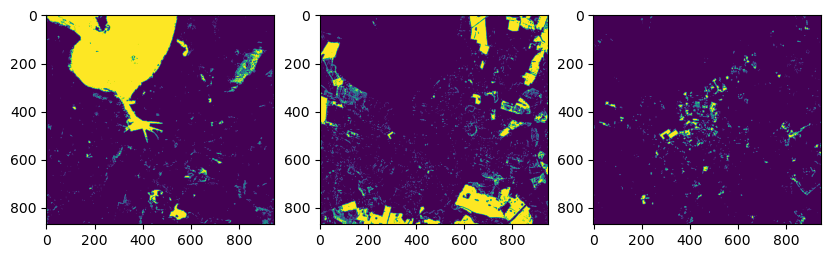

In [372]:
wismar_10m.gen_threshold_mat("water",0.9)
wismar_10m.gen_threshold_mat("vegetation",0.2, 0)
wismar_10m.gen_threshold_mat("urban",0.8)
wismar_10m.vis_threshold_mat()

In [374]:
wismar_10m.gen_vis_clf_map()

TypeError: 'Clf' object cannot be interpreted as an integer

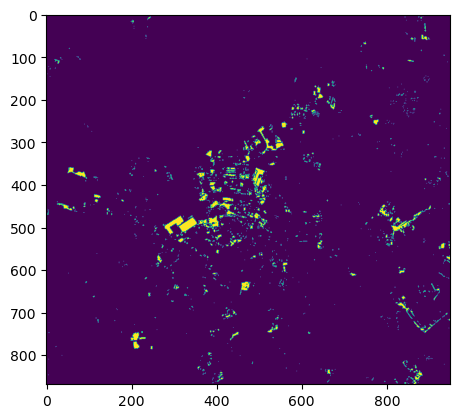

In [354]:
img2 = np.where(wismar_10m.distance_mat["urban"] >= 0.8, 1, 0)
plt.imshow(img2)

In [355]:
img2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

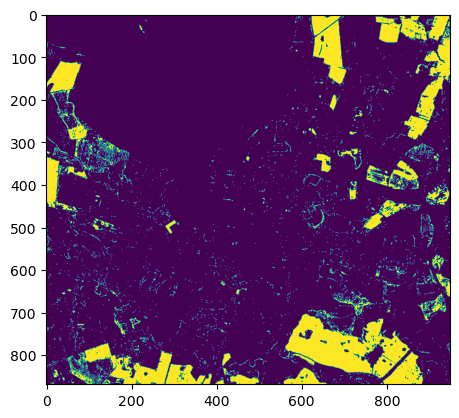

In [349]:
img = np.where(wismar_10m.distance_mat["vegetation"] <= 0.2, 1, 0)
plt.imshow(img)

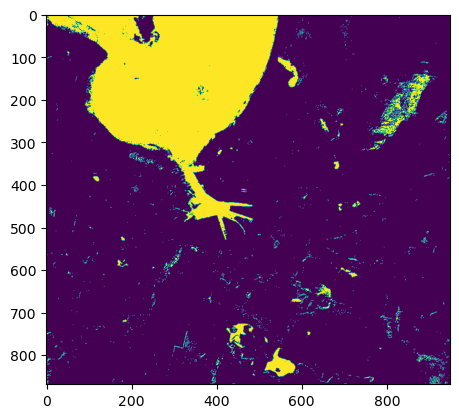

In [350]:
img1 = np.where(wismar_10m.distance_mat["water"] >= 0.9, 1, 0)
plt.imshow(img1)

In [17]:
# classify every pixel, show the classification map

### Discussion

Do you think the points are representative for the classes? Why?
What are the strengths and weaknesses of this classification?
What could be done to improve the classification?

Expected extend: 2 short paragraphs (6-10 sentences)

*Write your discussion here...*

# 5. Applying a smoothing filter

In this task you should create a kernel that smoothest the image in hopes to make the second classification less noisy.
You may use scipy convolution to apply the filter.

In [ ]:
# apply a smoothing filter


# 6. Recreate the 3-class pixelwise-classification map (plus discussion of differences).

Recreate the 3-class pixelwise-classification map for the smoothed image. You should use the same representative points and functions as in task 4 for the classification.
Display the original and smoothed image and the classification (e.g., in a 2x2 grid) to compare the results.

*Note: Do not smooth the classification map. Instead, smooth the image and classify again.*

In [ ]:
# smooth the image, show original, smoothed, classified(original) and classified (smoothed) images

### Discussion

Why did you choose this kernel? 
What is the effect of the kernel on the image? 
How does the classification change?
Do you think the classification is better after applying the filter?

Expected extend: 2 short paragraphs (6-10 sentences)

*Write your discussion here...*

# 7. Creating a binary pixelwise-classification map and run edge detection (plus discussion).

Create a binary pixelwise-classification map for the region of interest. Use the envelope of the region of interest as the area of interest for the classification.
You may use the classification from task 4 or task 6 for this task.

The binary classification should have the following classes:
1. belong to the class X (X is one of the classes from task 4 or task 6)
2. do not belong to the class X.

After creating the binary classification, apply edge detection to the binary classification map.
You may not use a well-known edge detection filter (e.g., Sobel, Canny, etc.) for this task, but create your own edge detection filter.
You may again use the scipy convolution to apply the filter.

Visualize the binary classification map, the edge detection map, the used classification map, and the true color image used for the classification.

In [ ]:
# binarize, define a custom edge detection kernel, visualize the 4 images

### Discussion

Why did you choose this kernel for the edge detection?
What is the effect of the kernel on the binary classification map?
Do you think the edge detection is successful?
Which map did you use for the edge detection and why?

Expected extend: 2 short paragraphs (6-10 sentences)

*Write your discussion here...*

## Submission

- Follow the instructions mentioned in this notebook.
- You are _not_ allowed to install other libraries.
- Explain the steps that went into the decision-making of the specific values if applicable in the respective discussions.
- It is essential that each homework should be done individually! We will check for plagiarism.
- The notebook should have been executed once before submitting it
    - The notebook should _not_ be _cleaned_ before submitting
    - Before the final submission, delete all intermediate files (e.g. downloaded files) and then "Restart the kernel and run all cells" (⏩ in the top left)
- Do not submit your copernicus secret!

Each student should submit the following materials to the ISIS system:
- One `zip` file containing the jupyter notebook named as: `IP4RS2024-HW1_<NAME_SURNAME>.zip`, e.g. `IP4RS2024-HW1_Riley_Exampleperson.zip` and nothing else.
